# ORF recognition by Convolutional/Recurrent
Attempting to train the model on simulated RNA sequences of length 256.



In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-07-01 17:38:58 UTC'

In [2]:
#Input
PC_SEQUENCES=64000   # how many protein-coding sequences
NC_SEQUENCES=64000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=256            # how long is each sequence
CDS_LEN=128            # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs

#Model
FILTERS = 32   # how many different patterns the model looks for
CELLS = 128 #Used in LSTM layer(s)
NEURONS = 128 #Used in Dense layer(s)
DROP_RATE = 0.05
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases

#Training
EPOCHS=50  # how many times to train on all the data
SPLITS=3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=3  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    from RNA_describe import Random_Base_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import prepare_inputs_len_x_alphabet
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter,Random_Base_Oracle
        from SimTools.RNA_prep import prepare_inputs_len_x_alphabet

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login


On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import GRU,LSTM
from keras.layers import Flatten,TimeDistributed
from keras.layers import MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
rbo=Random_Base_Oracle(RNA_LEN,True)
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,10) # just testing
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 58 trials to reach 10 per class.
It took 360381 trials to reach 65000 per class.
Use 65000 PC seqs
Use 65000 NC seqs


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 256.0
Average ORF length: 156.56455384615384
NC seqs
Average RNA length: 256.0
Average ORF length: 67.68724615384616


In [7]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [8]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [9]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same")) #Testing
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same")) #Testing
    dnn.add(MaxPooling1D()) #Testing
    #dnn.add(TimeDistributed(Flatten()))
    dnn.add(LSTM(CELLS,return_sequences=True))
    dnn.add(LSTM(CELLS,return_sequences=False))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    #dnn.build(input_shape=INPUT_SHAPE)   
    dnn.build()   
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (256, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 256, 32)           416       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 32)           3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 128, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 128, 32)           3104      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 128, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 32)            0         
_________________________________________________________________
lstm (LSTM)              

In [10]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (256, 4)
FIT
Epoch 1/50
2667/2667 [==============================] - 59s 15ms/step - loss: 0.6978 - accuracy: 0.5045 - val_loss: 0.6922 - val_accuracy: 0.5201


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.6957 - accuracy: 0.5082 - val_loss: 0.6920 - val_accuracy: 0.5298


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 3/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.6919 - accuracy: 0.5248 - val_loss: 0.6774 - val_accuracy: 0.5812


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 4/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.6566 - accuracy: 0.6102 - val_loss: 0.6395 - val_accuracy: 0.6345


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 5/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.6281 - accuracy: 0.6463 - val_loss: 0.6120 - val_accuracy: 0.6632


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 6/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.6037 - accuracy: 0.6744 - val_loss: 0.5918 - val_accuracy: 0.6812


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 7/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.5845 - accuracy: 0.6854 - val_loss: 0.5862 - val_accuracy: 0.6863


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 8/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.5779 - accuracy: 0.6905 - val_loss: 0.5923 - val_accuracy: 0.6854
Epoch 9/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.5746 - accuracy: 0.6948 - val_loss: 0.5800 - val_accuracy: 0.6904


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 10/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.5705 - accuracy: 0.6976 - val_loss: 0.5811 - val_accuracy: 0.6887
Epoch 11/50
2667/2667 [==============================] - 39s 14ms/step - loss: 0.5685 - accuracy: 0.6994 - val_loss: 0.5811 - val_accuracy: 0.6906


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 12/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.5657 - accuracy: 0.7013 - val_loss: 0.5906 - val_accuracy: 0.6829
Epoch 13/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.5623 - accuracy: 0.7034 - val_loss: 0.5787 - val_accuracy: 0.6930


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 14/50
2667/2667 [==============================] - 43s 16ms/step - loss: 0.5575 - accuracy: 0.7071 - val_loss: 0.5757 - val_accuracy: 0.6945


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 15/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.5562 - accuracy: 0.7090 - val_loss: 0.5790 - val_accuracy: 0.6899
Epoch 16/50
2667/2667 [==============================] - 41s 15ms/step - loss: 0.5526 - accuracy: 0.7098 - val_loss: 0.5778 - val_accuracy: 0.6890
Epoch 17/50
2667/2667 [==============================] - 41s 15ms/step - loss: 0.5479 - accuracy: 0.7136 - val_loss: 0.5795 - val_accuracy: 0.6955


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 18/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.5460 - accuracy: 0.7140 - val_loss: 0.5764 - val_accuracy: 0.6941
Epoch 19/50
2667/2667 [==============================] - 41s 15ms/step - loss: 0.5397 - accuracy: 0.7183 - val_loss: 0.5784 - val_accuracy: 0.6924
Epoch 20/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.5383 - accuracy: 0.7185 - val_loss: 0.5939 - val_accuracy: 0.6817
Epoch 21/50
2667/2667 [==============================] - 41s 15ms/step - loss: 0.5358 - accuracy: 0.7211 - val_loss: 0.5826 - val_accuracy: 0.6913
Epoch 22/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.5288 - accuracy: 0.7254 - val_loss: 0.5847 - val_accuracy: 0.6899
Epoch 23/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.5233 - accuracy: 0.7312 - val_loss: 0.5830 - val_accuracy: 0.6877
Epoch 24/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.5199 - accuracy: 0.7324 - val_loss: 0

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 33/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.4565 - accuracy: 0.7793 - val_loss: 0.5471 - val_accuracy: 0.7282


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 34/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.5281 - accuracy: 0.7091 - val_loss: 0.6693 - val_accuracy: 0.5938
Epoch 35/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.6571 - accuracy: 0.6098 - val_loss: 0.6303 - val_accuracy: 0.6467
Epoch 36/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.6092 - accuracy: 0.6683 - val_loss: 0.5683 - val_accuracy: 0.7050
Epoch 37/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.5212 - accuracy: 0.7402 - val_loss: 0.5709 - val_accuracy: 0.7053
Epoch 38/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.5507 - accuracy: 0.7187 - val_loss: 0.5507 - val_accuracy: 0.7207
Epoch 39/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.4975 - accuracy: 0.7602 - val_loss: 0.4486 - val_accuracy: 0.7916


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 40/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.5082 - accuracy: 0.7484 - val_loss: 0.6483 - val_accuracy: 0.6264
Epoch 41/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.6171 - accuracy: 0.6575 - val_loss: 0.5030 - val_accuracy: 0.7549
Epoch 42/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.5005 - accuracy: 0.7573 - val_loss: 0.5470 - val_accuracy: 0.7207
Epoch 43/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.5672 - accuracy: 0.7044 - val_loss: 0.6440 - val_accuracy: 0.6286
Epoch 44/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.6333 - accuracy: 0.6379 - val_loss: 0.6214 - val_accuracy: 0.6527
Epoch 45/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.6154 - accuracy: 0.6628 - val_loss: 0.6051 - val_accuracy: 0.6747
Epoch 46/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.6324 - accuracy: 0.6430 - val_loss: 0

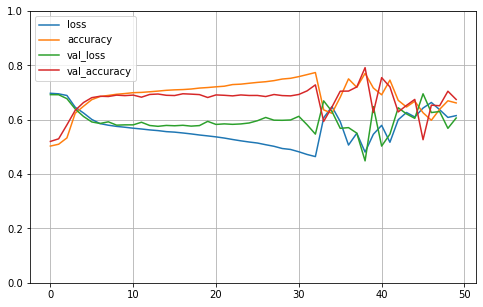

MODEL
make_DNN
input shape: (256, 4)
FIT
Epoch 1/50
2667/2667 [==============================] - 45s 16ms/step - loss: 0.6983 - accuracy: 0.4990 - val_loss: 0.6949 - val_accuracy: 0.5011
Epoch 2/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.6956 - accuracy: 0.5023 - val_loss: 0.6948 - val_accuracy: 0.4989
Epoch 3/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.6937 - accuracy: 0.5059 - val_loss: 0.6920 - val_accuracy: 0.5239
Epoch 4/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.6923 - accuracy: 0.5210 - val_loss: 0.6846 - val_accuracy: 0.5571
Epoch 5/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.6842 - accuracy: 0.5554 - val_loss: 0.6709 - val_accuracy: 0.5888
Epoch 6/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.6591 - accuracy: 0.6063 - val_loss: 0.6284 - val_accuracy: 0.6453
Epoch 7/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.633

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 29/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.3382 - accuracy: 0.8546 - val_loss: 0.3008 - val_accuracy: 0.8735


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 30/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.2471 - accuracy: 0.9009 - val_loss: 0.1801 - val_accuracy: 0.9311


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 31/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.1858 - accuracy: 0.9285 - val_loss: 0.1722 - val_accuracy: 0.9350


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 32/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.1591 - accuracy: 0.9400 - val_loss: 0.1551 - val_accuracy: 0.9426


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 33/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.1420 - accuracy: 0.9497 - val_loss: 0.1193 - val_accuracy: 0.9562


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 34/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.1200 - accuracy: 0.9558 - val_loss: 0.1178 - val_accuracy: 0.9575


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 35/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.1141 - accuracy: 0.9593 - val_loss: 0.0982 - val_accuracy: 0.9640


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 36/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.1027 - accuracy: 0.9633 - val_loss: 0.1268 - val_accuracy: 0.9567
Epoch 37/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.1209 - accuracy: 0.9588 - val_loss: 0.0946 - val_accuracy: 0.9658


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 38/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.0946 - accuracy: 0.9673 - val_loss: 0.0824 - val_accuracy: 0.9712


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 39/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.3059 - accuracy: 0.8545 - val_loss: 0.1997 - val_accuracy: 0.9329
Epoch 40/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.1622 - accuracy: 0.9415 - val_loss: 0.1096 - val_accuracy: 0.9610
Epoch 41/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.1034 - accuracy: 0.9642 - val_loss: 0.0936 - val_accuracy: 0.9651
Epoch 42/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.0842 - accuracy: 0.9709 - val_loss: 0.0828 - val_accuracy: 0.9715


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 43/50
2667/2667 [==============================] - 39s 15ms/step - loss: 0.1903 - accuracy: 0.9283 - val_loss: 0.1163 - val_accuracy: 0.9566
Epoch 44/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.1144 - accuracy: 0.9635 - val_loss: 0.1037 - val_accuracy: 0.9619
Epoch 45/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.0874 - accuracy: 0.9715 - val_loss: 0.1282 - val_accuracy: 0.9570
Epoch 46/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.1129 - accuracy: 0.9633 - val_loss: 0.1160 - val_accuracy: 0.9643
Epoch 47/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.1361 - accuracy: 0.9504 - val_loss: 0.1289 - val_accuracy: 0.9548
Epoch 48/50
2667/2667 [==============================] - 39s 14ms/step - loss: 0.2958 - accuracy: 0.8640 - val_loss: 0.3875 - val_accuracy: 0.8322
Epoch 49/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.2827 - accuracy: 0.8870 - val_loss: 0

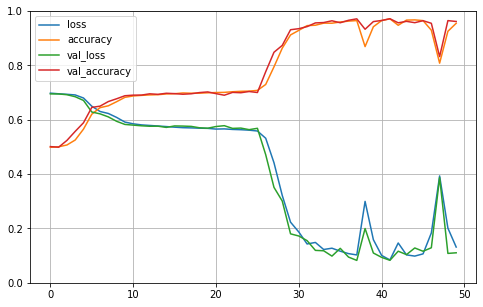

MODEL
make_DNN
input shape: (256, 4)
FIT
Epoch 1/50
2667/2667 [==============================] - 45s 15ms/step - loss: 0.6988 - accuracy: 0.4982 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 2/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.6952 - accuracy: 0.5043 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 3/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.6934 - accuracy: 0.5137 - val_loss: 0.6925 - val_accuracy: 0.5151
Epoch 4/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.6907 - accuracy: 0.5285 - val_loss: 0.6930 - val_accuracy: 0.5081
Epoch 5/50
2667/2667 [==============================] - 41s 15ms/step - loss: 0.6877 - accuracy: 0.5389 - val_loss: 0.6810 - val_accuracy: 0.5658
Epoch 6/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.6572 - accuracy: 0.6087 - val_loss: 0.6326 - val_accuracy: 0.6421
Epoch 7/50
2667/2667 [==============================] - 40s 15ms/step - loss: 0.625

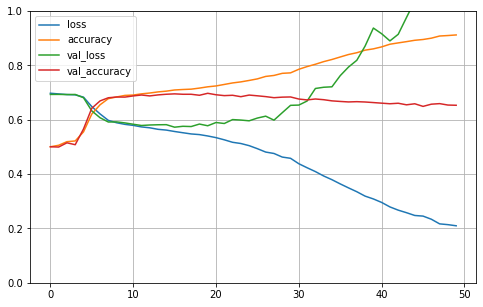

In [11]:
do_cross_validation(X,y)

In [12]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 97.30%


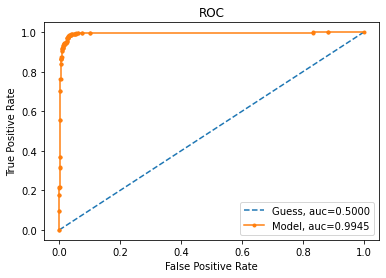

AUC: 99.45%


In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [14]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-07-01 19:24:27 UTC'